### Download data

In [ ]:
!pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip /content/intel-image-classification.zip

### Importing Libraries

In [15]:
import glob as gb
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import os

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import classification_report

### Import and Format data

In [2]:
# Label mappings
labels = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}


train_folder = f'/content/seg_train/seg_train/'
test_folder = f'/content/seg_test/seg_test/'

# Training data
train_img = []
train_lb = []

# Size
SIZE = (224, 224)

# Training Data loader
for folder in os.listdir(train_folder):
    folder_path = os.path.join(train_folder, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    for f in files:
        image = Image.open(f)
        image = image.resize(SIZE)

        train_img.append(np.array(image))
        train_lb.append(labels.get(folder))

train_img = np.array(train_img)
train_lb = np.array(train_lb)

# Test data Loader
test_img = []
test_lb = []

for folder in os.listdir(test_folder):
    folder_path = os.path.join(test_folder, folder)
    files = gb.glob(os.path.join(folder_path, '*.jpg'))
    for f in files:
        image = Image.open(f)
        image = image.resize(SIZE)

        test_img.append(np.array(image))
        test_lb.append(labels.get(folder))

test_img = np.array(test_img)
test_lb = np.array(test_lb)

print(f"No. of images in training set {len(train_img)}")
print(f"No. of images in test set {len(test_img)}")

No. of images in training set 14034
No. of images in test set 3000


### Sampling Data

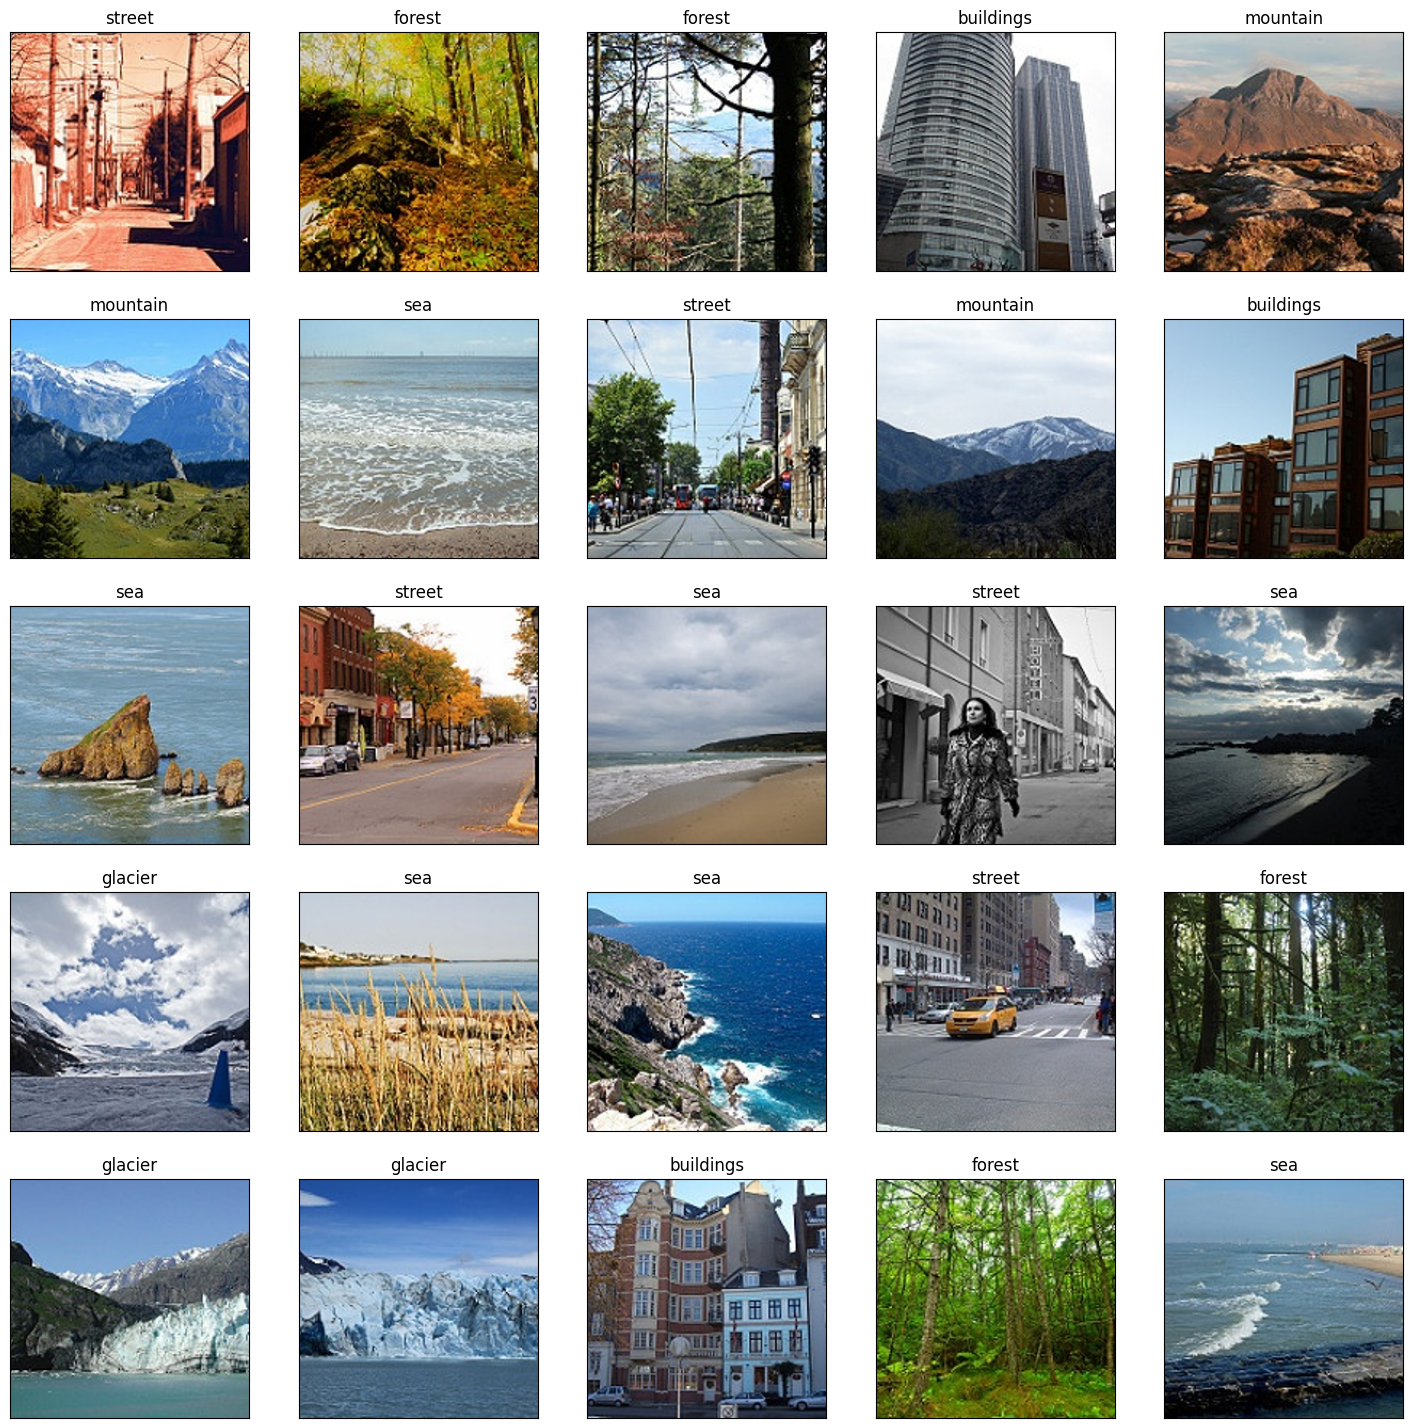

In [5]:
plt.figure(figsize=(18, 18))

random_list = random.sample(range(13001), 25)
i = 0
for j in random_list:
    plt.subplot(5, 5, i+1)
    plt.imshow(train_img[j])
    label_code = train_lb[j]
    label_name = [key for key, value in labels.items() if value == label_code][0]
    plt.title(label_name)
    plt.xticks([])
    plt.yticks([])
    i+=1

plt.show()

### Building Model

In [3]:
model = tf.keras.Sequential([
    # Conv2D 1
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (5,5), strides = (1,1), padding = 'same', activation = 'relu', input_shape = train_img[0].shape),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
    tf.keras.layers.Dropout(0.2),

    # Conv2D 2
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (5,5),  activation = 'relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)),
    tf.keras.layers.Dropout(0.4),

    # Dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(6, activation = tf.nn.softmax)

])

In [ ]:
# Model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 64)      51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0

### Model Training

In [4]:
import gc
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [7]:
# Compile the model
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
early = EarlyStopping(patience = 5, restore_best_weights = True)
g = GarbageCollectorCallback()
# Train the model
history = model.fit(train_img, train_lb, epochs = 5, validation_data = (test_img, test_lb), callbacks = [early, g])
gc.collect()

Epoch 1/5
  6/439 [..............................] - ETA: 45s - loss: 0.3860 - accuracy: 0.8594

439/439 [==============================] - 48s 107ms/step - loss: 0.4270 - accuracy: 0.8545 - val_loss: 0.8806 - val_accuracy: 0.7160
Epoch 2/5
439/439 [==============================] - 44s 100ms/step - loss: 0.3033 - accuracy: 0.8970 - val_loss: 1.4618 - val_accuracy: 0.6723
Epoch 3/5
439/439 [==============================] - 44s 100ms/step - loss: 0.2270 - accuracy: 0.9246 - val_loss: 0.9022 - val_accuracy: 0.7493
Epoch 4/5
439/439 [==============================] - 44s 99ms/step - loss: 0.1857 - accuracy: 0.9401 - val_loss: 1.0208 - val_accuracy: 0.7347
Epoch 5/5
439/439 [==============================] - 45s 103ms/step - loss: 0.1591 - accuracy: 0.9478 - val_loss: 1.1801 - val_accuracy: 0.7550


1354

### Model Evaluation

In [7]:
loss , acc = model.evaluate(train_img , train_lb)
print("Accuracy : ",acc)
print("loss : " , loss)

439/439 [==============================] - 7s 15ms/step - loss: 0.6022 - accuracy: 0.7752
Accuracy :  0.7751888036727905
loss :  0.6022003293037415


### Model Prediction

In [8]:
gc.collect()
folder_pred = r"/content/seg_pred/seg_pred"

for folder in os.listdir(folder_pred):
    folder_files = os.path.join(folder_pred, folder)
    files = gb.glob(pathname=os.path.join(folder_files, "*.jpg"))
    print(f"For files in folder {folder}, the number of items is {len(files)}")

Streaming output truncated to the last 5000 lines.
For files in folder 5851.jpg, the number of items is 0
For files in folder 23599.jpg, the number of items is 0
For files in folder 12954.jpg, the number of items is 0
For files in folder 12554.jpg, the number of items is 0
For files in folder 10758.jpg, the number of items is 0
For files in folder 22274.jpg, the number of items is 0
For files in folder 21673.jpg, the number of items is 0
For files in folder 18062.jpg, the number of items is 0
For files in folder 9917.jpg, the number of items is 0
For files in folder 23086.jpg, the number of items is 0
For files in folder 13670.jpg, the number of items is 0
For files in folder 21642.jpg, the number of items is 0
For files in folder 20547.jpg, the number of items is 0
For files in folder 23422.jpg, the number of items is 0
For files in folder 16603.jpg, the number of items is 0
For files in folder 25.jpg, the number of items is 0
For files in folder 11643.jpg, the number of items is 0
Fo

In [9]:
def get_key_from_value(dictionary, value):
    return next((key for key, val in dictionary.items() if val == value), None)

94/94 [==============================] - 1s 14ms/step


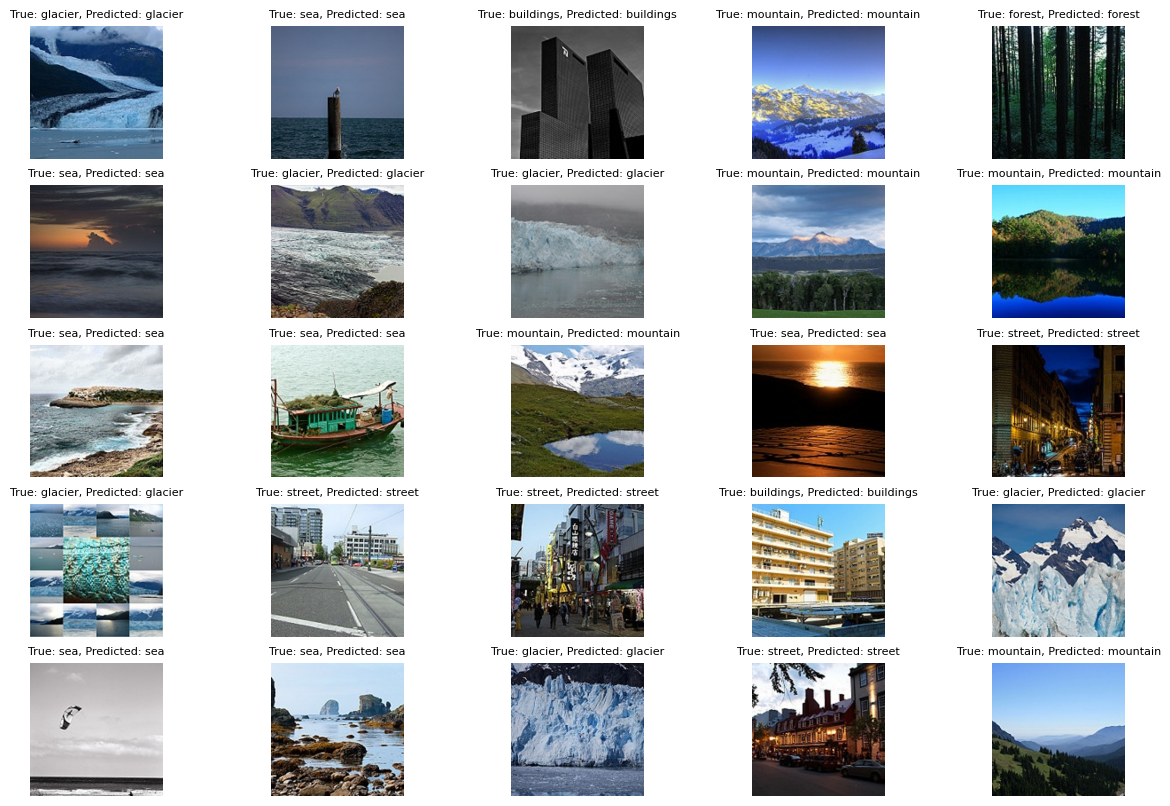

In [13]:
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(test_img)

# Assuming predictions is a NumPy array
predicted_classes = np.argmax(predictions, axis=1)

# Assuming test_img and test_lb have correct shapes and data types
plt.figure(figsize=(15, 10))
random_list2 = random.sample(range(len(test_img)), 25)  # Assuming test_img has length 7001
j = 0
for i in random_list2:
    plt.subplot(5, 5, j + 1)
    plt.imshow(test_img[i], cmap='gray')

    label1 = get_key_from_value(labels, test_lb[i])  # Assuming labels is a dictionary
    label_code = test_lb[i]
    label_name = [key for key, value in labels.items() if value == label_code][0]

    plt.title(f"True: {label1}, Predicted: {label_name}", fontsize=8)
    plt.axis('off')
    j += 1
plt.show()

In [14]:
model.save("model.h5")

In [16]:
class_labels = list(labels.keys())
print("\nClassification Report:")
print(classification_report(test_lb, predicted_classes, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

   buildings       0.75      0.65      0.70       437
      forest       0.94      0.93      0.93       474
     glacier       0.73      0.72      0.72       553
    mountain       0.66      0.70      0.68       525
         sea       0.70      0.73      0.71       510
      street       0.78      0.82      0.80       501

    accuracy                           0.76      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.76      0.76      0.75      3000

